In [3]:
import numpy as np
import warnings
from scipy.io import loadmat
from LFSpy import LocalFeatureSelection
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn import datasets
import matplotlib.pyplot as plt

np.random.seed(905)


In [4]:

def load_dataset(name, m=0):
    '''
    Loads a test/demo dataset.
    '''
    print('Loading dataset ' + name + '...')
    if name is 'sample':
        mat = loadmat('matlab_Data')
        training_data = mat['Train'].T
        training_labels = mat['TrainLables'][0]
        testing_data = mat['Test'].T
        testing_labels = mat['TestLables'][0]
        
    elif name is 'iris':
        # we only take the first two classes for binary classification
        train_idx = np.arange(0, 100, 2)
        test_idx = np.arange(1, 100, 2)
        
        iris = datasets.load_iris()
        
        if m > 0:
            iris.data = add_noise_vars(iris.data, m)
        
        training_data = iris.data[train_idx,:]
        training_labels = iris.target[train_idx]
        testing_data = iris.data[test_idx,:]
        testing_labels = iris.target[test_idx]
    
    return training_data, training_labels, testing_data, testing_labels

In [5]:

def add_noise_vars(x, m, std_range=[0,3]):
    '''
    Adds m Gaussian noise variables to data array x. Gaussian distribution have 
    zero mean with standard deviations sampled from a uniform distribution on
    std_range.
    '''
    n = x.shape[0]
    stds = np.random.uniform(low=std_range[0], high=std_range[1], size=m)
    noise_vars = [np.random.normal(loc=0.0, scale=s, size=[n,]) for s in stds]
    return np.hstack((x, np.stack(noise_vars).T))

In [8]:
def results_lfspy(x_train, y_train, x_test, y_test):
    '''
    Trains an tests and LFS model using default parameters on the given dataset.
    '''
    print('Training and testing an LFS model with default parameters.\nThis may take a few minutes...')
    lfs = LocalFeatureSelection(rr_seed=777)
    pipeline = Pipeline([('classifier', lfs)])
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    score = pipeline.score(x_test, y_test)
    
    return score, y_pred

In [9]:

def results_rforest(x_train, y_train, x_test, y_test):
    print('Training and testing a Random Forest with default parameters.')
    rfc = RandomForestClassifier(random_state=777)
    pipeline = Pipeline([('classifier', rfc)])
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    score = pipeline.score(x_test, y_test)
    
    return score, y_pred


In [10]:

def results_fsvm(x_train, y_train, x_test, y_test):
    print('Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).')
    svm = LinearSVC(random_state=777)
    sel = SelectKBest(f_classif, k=int(0.25*x_train.shape[1]))
    pipeline = Pipeline([('feat_sel', sel), ('classifier', svm)])
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    score = pipeline.score(x_test, y_test)
    
    return score, y_pred

In [11]:

training_data, training_labels, testing_data, testing_labels = load_dataset('sample')
score_lfs, y_pred_lfs = results_lfspy(training_data, training_labels, testing_data, testing_labels)
score_rfc, y_pred_rfc = results_rforest(training_data, training_labels, testing_data, testing_labels)
score_svm, y_pred_svm = results_fsvm(training_data, training_labels, testing_data, testing_labels)

training_data, training_labels, testing_data, testing_labels = load_dataset('iris')
score_lfs_iris, y_pred_lfs_iris = results_lfspy(training_data, training_labels, testing_data, testing_labels)
score_rfc_iris, y_pred_rfc_iris = results_rforest(training_data, training_labels, testing_data, testing_labels)
score_svm_iris, y_pred_svm_iris = results_fsvm(training_data, training_labels, testing_data, testing_labels)

# Plot the comparison of results
scores = [score_lfs, score_rfc, score_svm]
scores_iris = [score_lfs_iris, score_rfc_iris, score_svm_iris]

Loading dataset sample...
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Loading dataset iris...
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).


In [12]:
def plotScores(scores, title=None):
    '''
    Plot classification scores.
    '''
    plt.figure()
    plt.bar(['LFS','RFC','SVM'], scores)
    plt.ylim([0,1])    

    for i, v in enumerate(scores):
        plt.text(i - 0.1, 0.4, '{:.{}f}'.format(v,2), size=12)
    
    plt.title(title, fontsize=14)
    plt.savefig(title+'.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
    return None

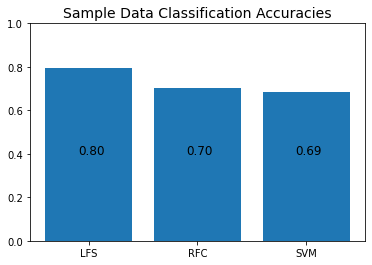

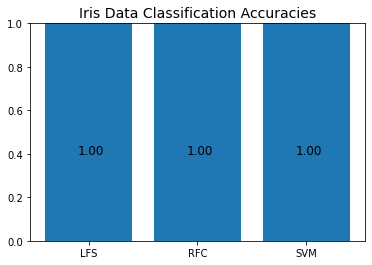

In [13]:

plotScores(scores, 'Sample Data Classification Accuracies')
plotScores(scores_iris, 'Iris Data Classification Accuracies')

In [14]:

# %% Compare across number of noise variables on Iris dataset
Score_LFS = []
Score_SVM = []
Score_RFC = []
mlist = np.arange(0, 1001, 25)
for m in mlist:
    training_data, training_labels, testing_data, testing_labels = load_dataset('iris', m=m)
    
    s1, _ = results_lfspy(training_data, training_labels, testing_data, testing_labels)
    s2, _ = results_rforest(training_data, training_labels, testing_data, testing_labels)
    s3, _ = results_fsvm(training_data, training_labels, testing_data, testing_labels)
    
    Score_LFS.append(s1)
    Score_RFC.append(s2)
    Score_SVM.append(s3)

# Plot the results
plt.figure()
plt.plot(mlist, Score_LFS)
plt.plot(mlist, Score_RFC)
plt.plot(mlist, Score_SVM)
plt.vlines(100, 0, 1.2, linestyles='dashed')
plt.ylim([0,1.2]) 

#plt.xlabel('Number of Noise Features')
plt.title('Classification Accuracy by Number of Added Noise Variables', fontsize=14)
plt.legend(['LFS','Random Forest','SVM'], loc='lower right')
plt.show()
# plt.savefig('IrisData_noise_Results.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

Loading dataset iris...
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Loading dataset iris...
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Loading dataset iris...
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random Forest with default parameters.
Training and testing a SVM with default parameters with F-stat feature selection (25% of features selected).
Loading dataset iris...
Training and testing an LFS model with default parameters.
This may take a few minutes...
Training and testing a Random F

KeyboardInterrupt: 